In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from MapTools_py import map_elements as mel


BBECA = gpd.read_file('BB_Data/Spatial/ECOSYS_REV_TEM.shp')
BBECA = BBECA[['PRISTINE', 'ECO', 'MAP_UNIT', 'geometry']]

Classes = {
    'Water Lily - Watersh':'Water',
    'Herb. veg on dist. p':'Disturbed',
    'Open Water':'Water',
    'Cultivated Field':'Disturbed',
    'Disturbed Surface':'Disturbed',
    'Hardhack Thicket':'Forested',
    'Birch Forest':'Forested',
    'Mixed Conifer Forest':'Forested',
    'Pine-Salal Forest':'Forested',
    'Pine Sphagnum Woodla':'Pine\nSphagnum',
    'Beakrush - Three-way':'Sedge\nSphagnum',
    'Pine Sphagnum Tall S':'Pine\nSphagnum',
    'Beakrush - Sphagnum':'Sedge\nSphagnum',
    'Pine Sphagnum Low Sh':'Pine\nSphagnum',
}

Colors ={
    'Pine\nSphagnum':'#76bd68',#light green
    'Sedge\nSphagnum':'#0eb0a5',#dark teal
    'Forested':'#193d02',#dark green
    'Disturbed':'#f2ef8a',#light yellow
    'Water':'#053ba8'#dark blue
}

BBECA['Class'] = BBECA['MAP_UNIT']
BBECA['Class'] = BBECA['Class'].replace(Classes)

BBECA.loc[BBECA['Class']=='Other','MAP_UNIT']='Other'

BBECA['AREA_sqKM']=BBECA.area.values/1e6

Towers = gpd.read_file('BB_Data/Spatial/Towers.shp')
Towers.loc[Towers['Name']=='Sapling_NoTreatment','Name']='BBS'
Towers['X'] = Towers.geometry.x
Towers['Y'] = Towers.geometry.y

Burn = gpd.read_file('BB_Data/Spatial/SeedlingRemoval.shp')

Chambers = gpd.read_file('BB_Data/Spatial/Chamber_Sites_2016_Burn_Zone.shp')
for eco_type in BBECA['MAP_UNIT'].unique():
    unit = BBECA.loc[BBECA['MAP_UNIT']==eco_type].dissolve().geometry[0]
    Chambers.loc[Chambers.geometry.intersects(unit)==True,'Unit'] = eco_type.replace(
        'Pine Sphagnum ','').replace('Low Sh','Low Shurb').replace('Tall S','Tall Shurb').replace('Woodla','Woodland')

Chambers=Chambers[['geometry','Unit']].copy()

Grid = gpd.read_file('BB_Data/Spatial/SeedlingRemoval.shp')
Grid.loc[Grid['year_done']!='2024','Treatment']='Seedling Removal'
Grid.loc[Grid['year_done']=='2024','Treatment']='Control'
Grid = Grid[['geometry','Treatment']].copy()
Grid = Grid.dissolve(by='Treatment')

for i,row in Grid.iterrows():
    unit = row.geometry
    Chambers.loc[Chambers.geometry.intersects(unit)==True,'Treatment'] = i
    Chambers.loc[Chambers.geometry.intersects(unit)==True,'Zone'] = 2016
    
Chambers['Treatment']=Chambers['Treatment'].fillna('Control')
Chambers['Zone']=Chambers['Zone'].fillna(2005)

Chambers.loc[Chambers['Treatment']=='Seedling Removal','marker']='^'
Chambers.loc[Chambers['Treatment']=='Control','marker']='v'

Chambers['geometry'] = Chambers.buffer(50)
Chambers = Chambers.dissolve(by=['Unit','Treatment','Zone'])

Chambers['geometry']=Chambers.geometry.centroid


Eco = BBECA[['Class','AREA_sqKM','geometry']].dissolve(by='Class',aggfunc='sum')
Eco['Pct']=Eco['AREA_sqKM']/Eco['AREA_sqKM'].sum()
Eco = Eco.sort_values(by='Pct')
Eco.to_file('BB_Data/Ecosystem_Summary.shp')

for key,color in Colors.items():
    Eco.loc[Eco.index==key,'Color']=color

Chambers = Chambers.reset_index()

In [22]:
Boundary = BBECA[['geometry']].dissolve().explode(index_parts=True)
Boundary = Boundary.loc[Boundary.area>= 1e6].to_crs('WGS1984')
Boundary.to_file('BB_Data/Spatial/BBECA_Boundary.geojson',driver='GeoJSON')

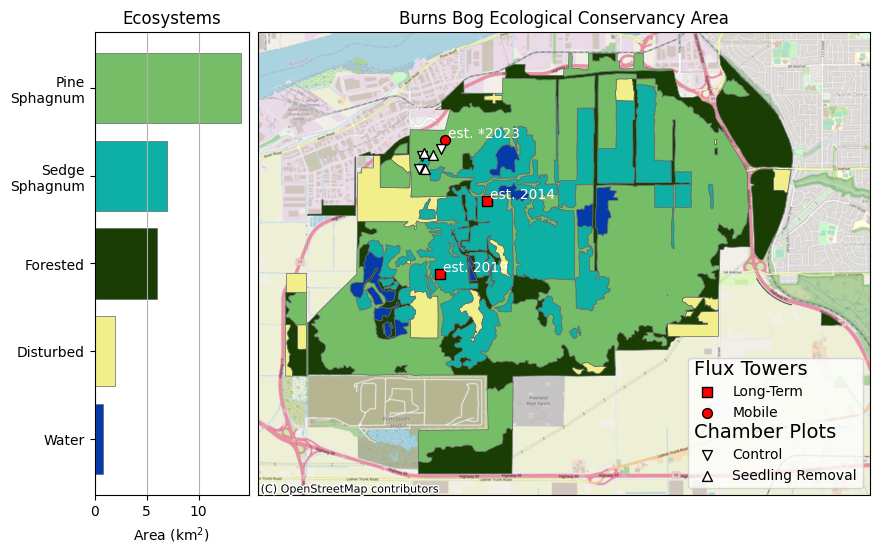

In [2]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(100, 100)
bar=fig.add_subplot(gs[7:93, 0:20])
map=fig.add_subplot(gs[0:, 21:])
Class_Patches = []
bar_ylbl = []
bar_ytick = []
for index,row in Eco.iterrows():
    kwargs = {
        'facecolor':row['Color'],
        'linewidth':.5,
        'edgecolor':'#646669'
        }
    Eco.loc[Eco.index==index].plot(ax=map,**kwargs)
    bar.barh(index,row['AREA_sqKM'],
             **kwargs)
bar.grid(axis='x')
bar.set_xlabel('Area (km$^2$)')
bar.set_title('Ecosystems')

kwargs = {
    'marker':'s',
    'facecolor':'r',
    'edgecolor':'k',
    's':50
    }

label_pad = 45

BB = Towers.loc[Towers['Name']!='BBS']
map.scatter(BB['X'],BB['Y'],
           label='Long-Term',
           **kwargs)
for i,row in BB.iterrows():
    map.text(row['X']+label_pad,row['Y']+label_pad,f'est. {int(row.Start)}',color='white')

kwargs['marker'] = 'o'
BBS = Towers.loc[Towers['Name']=='BBS']
map.scatter(BBS['X'],BBS['Y'],
           label='Mobile',
           **kwargs)
for i,row in BBS.iterrows():
    map.text(row['X']+label_pad,row['Y']+label_pad,f'est. *2023',color='white')

kwargs['facecolor'] ='white'
for treat in Chambers['Treatment'].unique():
    row = Chambers.loc[((Chambers['Zone']==2016)&(Chambers['Treatment']==treat))]
    kwargs['marker'] = row['marker'].iloc[0]
    # kwargs['facecolor'] = row['color']
    map.scatter(row.geometry.x,row.geometry.y,
           label=treat,
           **kwargs)

handles, labels = map.get_legend_handles_labels()
handles.insert(0,'Flux Towers')
labels.insert(0,'')

handles.insert(3,'Chamber Plots')
labels.insert(3,'')
map.legend(handles=(handles),labels=(labels),loc=4,
           handler_map={str: mel.LegendTitle({'fontsize': 14})})
map.get_xaxis().set_visible(False)
map.get_yaxis().set_visible(False)
map.set_title('Burns Bog Ecological Conservancy Area')


cx.add_basemap(map,source=cx.providers.OpenStreetMap.Mapnik, crs=BBS.crs)#, zoom=11)
plt.savefig('images/EcosystemMap.png',dpi=600)


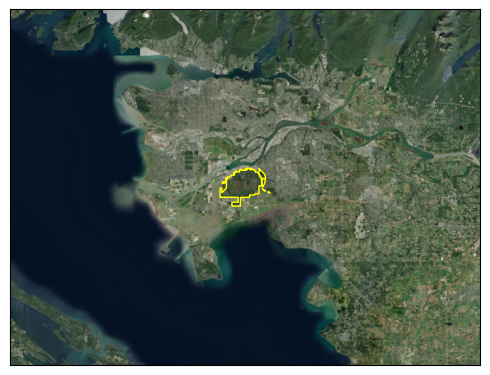

In [15]:
Boundary = BBECA.dissolve()

Scale = 27500

fig,ax=plt.subplots(figsize=(5,5))

access_token='pk.eyJ1IjoidWJjbWljcm9tZXQiLCJhIjoiY2xmMnJzYzlnMGFsYTNxcW1kYWhubjBiaSJ9.rhIOVatxQoS4M__qIFv6Pg'

tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(access_token)

Boundary.plot(ax=ax,facecolor='None',edgecolor='yellow')
xl = ax.get_xlim()
yl = ax.get_ylim()

aspect = ((xl[0]-xl[1])/(yl[0]-yl[1]))

ax.set_ylim(yl[0]-Scale,yl[1]+Scale)
ax.set_xlim(xl[0]-Scale*aspect,xl[1]+Scale*aspect)

cx.add_basemap(ax,source=tileurl, crs=Boundary.crs, zoom=12)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('images/Basemap.png',dpi=600)

In [4]:
import rasterio as rio
import numpy as np
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
path = "/mnt/g/My Drive/earthengine/"
name = "S2_Summer_Composite.tif"
new_name = "S2_Summer_Composite_projected.tif"


In [5]:
BBECA.crs


dst_crs = 'EPSG:26910'

Projected_Image = 'temp/FI_Projected.tif'

with rio.open(path+name) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(Projected_Image, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            # clip = pct_clip(rio.band(src, i))
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [6]:

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# ECC = pd.read_csv('BB_Data/DELTA BURNS BOG.csv',parse_dates=['LOCAL_DATE'])
# ECC = ECC.set_index('LOCAL_DATE')
# ECC_m = ECC[['TEMP']].groupby(ECC.index.month).mean()
# ECC_ym = ECC[['PRECIP_AMOUNT']].resample('m').sum()
# ECC_m['PRECIP_AMOUNT'] = ECC_ym.groupby(ECC_ym.index.month).mean()

# kwargs = {'color':'red','edgecolor':'k'}

# fig,ax=plt.subplots(2)
# ax[0].bar(ECC_m.index,ECC_m['TEMP'],**kwargs)
# kwargs['color']='blue'
# ax[1].bar(ECC_m.index,ECC_m['PRECIP_AMOUNT'],**kwargs)


# ECC.loc[ECC['WIND_DIRECTION']<=0,'WIND_DIRECTION']=np.nan

# ECC['WIND_DIRECTION'] = (ECC['WIND_DIRECTION']*10).round(0)
# ECC['WIND_BIN'] = pd.cut(ECC['WIND_DIRECTION'],np.linspace(0,360,17))
# bin_width = ECC['WIND_BIN'].apply(lambda x: (x.right-x.left)).mean()*np.pi/180


# ECC['WIND_BIN'] = ECC['WIND_BIN'].apply(lambda x: x.mid*np.pi/180)


# ECC_w = ECC.groupby('WIND_BIN').count()['WIND_DIRECTION']
# ECC_w = ECC_w/ECC_w.sum()

# fig, ax = plt.subplots(
#   subplot_kw = {'projection': 'polar'} 
# )
# ax.bar(ECC_w.index, ECC_w,
# width=bin_width,
# **kwargs)
# ax.set_rticks([0.05,.1,.15])
# ax.grid(True)
# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)
